# Initialization cell (always run)

In [1]:
#First, Import:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from copy import deepcopy
import matplotlib.colors as mcolors
import pandas as pd
from scipy import interpolate
from os.path import dirname, join as pjoin
import scipy.io as sio
import math
import scipy.linalg
import scipy.stats
import random
import scipy.special as sc
import time
import datetime
import os
import pickle
import matplotlib.colors as mcolors
from scipy.sparse import coo_matrix
from tqdm import tqdm
from scipy.optimize import fsolve

pi=np.pi
#import the notebook_setup directory of the nestpy folder from your computer: 
#(in practice you can probably just import nestpy, but since, as we say in the paper, 
#we rely on their tutorial, I saw no reason to change setup choice which we base things on):
%run /Users/itaybloch/Downloads/nestpyfolder/nestpy/tutorials/arxiv/setup_notebook.py

#Now define the basic function that simulates an S1,S2 signal from a specific event.



#the following func computes the S1,S2 one would get from the detector "detector", the interaction of type "interaction"
#on the energy vector energykeV. Note that there are other options which are currently ignored. 
#IMPORTANT TO NOTE: 
#1. This is mostly copied from the NEST tutorial (I changed a few things. Mostly to have it as one function+to pull detector details from the detector structure)
#2. THIS FUNCTION IS NOT VECTORIZED!!! ONLY USE GetS1_S2 WHICH SHOULD RUN FASTER AND IS A VECTORIZED VERSION OF THE SAME THING!!!
 
def GetS1_S2nonvec(interaction,#interaction=nestpy.nr for NR or #interaction=nestpy.beta for ER
                   energykeV,#energy in units of keV. In GetS1_S2 this is simply aa vector
                   detector,    #detector=nestpy.detectorname (e.g. nestpy.Detector_G3())
                   #The next variables are rough approximations.
                   #Since we are not an actual colaboration analyzing real data, this should be fine.
             #The following text is describing them, and is taken from the original NEST tutorial:
            # "these mean we don't compute photon times. 
            # it's a bit more crude but over 100x faster. 
            # So always do for a first-order approximation. "
             S1mode = nestpy.S1CalculationMode.Hybrid,   #Options are Full, Parametric, Hybrid, or Waveform
             S2mode = nestpy.S2CalculationMode.Full,     #Options are Full, or Waveform
             output_timing = 0,wftime = [0, 0, 0],wfamp = [0., 0., 0.]):
    A = 131.293 # avg atomic mass of Xe
    Z = 54. # Atomic number of Xe 
    nc= nestpy.NESTcalc(detector)#a shorthand.
    g2_params = nc.CalculateG2(False)#calculates the parameters of g2
    g2 = g2_params[3]
    drift_field=detector.FitEF(0,0,500)#I assume it is constant, since for XENONnT, G3, it is taken as such.
    density = nc.GetDensity( T=detector.get_T_Kelvin(), P=detector.get_p_bar(), inGas=False )#
    driftv = nc.SetDriftVelocity(detector.get_T_Kelvin(), density,drift_field)#drift velocity
    dv_mid =driftv#Again, drift velocity
    zminfiducial=detector.get_TopDrift()-detector.get_dt_max()*dv_mid#minimal z for the fiducial detector volume
    zmaxfiducial=detector.get_TopDrift()-detector.get_dt_min()*dv_mid#maximal z for the fiducial detector volume
    random_r = np.sqrt(np.random.uniform(0, detector.get_radius()**2)) #random sampling of the radius
    random_theta = np.random.uniform(0, 2*np.pi)#random angle
    truthposx, truthposy, truthposz = random_r*np.cos(random_theta), random_r*np.sin(random_theta),np.random.uniform(zminfiducial, zmaxfiducial)# sampling the location
    maxposz = detector.get_TopDrift() # max z position in mm  
    #We'll randomly select some positions to get realistic xyz smearing. 
    smearposx, smearposy, smearposz = truthposx, truthposy, truthposz # No smearing
    y = nc.GetYields(interaction,
     energykeV,
     density,
     drift_field,
     A,
     Z,
    ) #yield info
    q = nc.GetQuanta(y, density)#quanta info
    dt = np.abs((maxposz-truthposz)/driftv)#drift time
    S1 = nc.GetS1(q, truthposx, truthposy, truthposz,
                            smearposx, smearposy, smearposz,
                            driftv, dv_mid, # drift velocities (assume homogeneous drift field)
                            interaction, 1, #int type, event # 
                            drift_field, energykeV, #dfield, energy
                            S1mode, output_timing,
                            wftime,
                            wfamp)#S1
    S2 = nc.GetS2(q.electrons, 
                    truthposx, truthposy, truthposz,
                    smearposx, smearposy, smearposz,
                    dt, driftv, 1, #evt num
                    drift_field, S2mode, output_timing, # dv dvmid 
                    wftime, wfamp, 
                    g2_params)#S2
        # S1[7] is the spike area, corrected for xyz position, and dividing out dpe effect.
        # S2[7] here is cs2_b, again correcting for DPE, xyz position, DAQ smearing
    cs1=S1[7]
    cs2=S2[7]
    return cs1, cs2
GetS1_S2=np.vectorize(GetS1_S2nonvec)#A faster version of the above code.

currentdetector=nestpy.Detector_G3new()#I only work with this detector. This file is the one of LZ. 




#Now, some useful functions I like using (some not used here )
def atmost(anarray,atmostthis):#at most this thing
    return (-np.abs(anarray-atmostthis)+anarray+atmostthis)/2
def atleast(anarray,atleastthis):#at least this thing
    return (np.abs(anarray-atleastthis)+anarray+atleastthis)/2

#loads a pickle
def load_pkl(fullpath):
    with open(fullpath, 'rb') as f:
        return pickle.load(f)
#saves a pickle:
def save_pkl(obj,fullpath):
    with open(fullpath, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
#a running median
def RunningMedian(x,N):
    idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
    return np.median(x[idx],axis=1)

def running_mean(x, N):#a running mean
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

#tic() and toc() are used together to time something:
def tic():#First one defines tic() to start a clock
    return time.time()
def toc(t0):#then one tocs to find how much time passed since t0=tic().
    return time.time()-t0

nestpy version: v2.0.2
NEST version: v2.4.0


# Create Data for analysis

We first load the basic data. See provided data files.

In [2]:
fulldict={}#this is the variable that carries the most important information.
#I add things to it as the code progresses. To understand the most crucial parts of the code, one could
#probably do well by just following whenever this is mentioned.

#Paths to the different spectra. All should be in 1/keV/tonne/year
datafolder="/Users/itaybloch/Documents/GitHub/NeutrinoFogs/"#this is where one should put the spectra
solarnuNRpath=datafolder+"SolarnuNRBkg.csv"#solar neutrino NR spect.
othernupath=datafolder+"OtherNuNRBkg.csv"#other nu is the NR neutrinos that are not solar
solarnuERpath=datafolder+"SolarNuER.csv"#solar neutrino ER spect.
constantERpath=datafolder+"RnContaminationERBkg.csv"# This is the radion contamination. We mostly ignore it
                                                    #in our analysis, It is roughly constant.
whichsig=['Min','Max','MB'][2]#We have 3 datasets, the minimal one, the maximal one, and the maxwell boltzmann one. 
                                # this is both the name of the current signal, and (part of) the name of the spectrum file
sigpath0=datafolder+'dRdER$'+whichsig+'.txt'#the signal spectrum for the above choice.
#loading the datasets for each
datadict={}
datadict['Bkg_NR_othernu']= np.array(pd.read_csv(othernupath, header=None).iloc[:,:])
datadict['Bkg_NR_solarnu']= np.array(pd.read_csv(solarnuNRpath, header=None).iloc[:,:])
datadict['Bkg_ER_solarnu']= np.array(pd.read_csv(solarnuERpath, header=None).iloc[:,:])
datadict['Bkg_ER_const']=np.array(pd.read_csv(constantERpath, header=None).iloc[:,:])
datadict[whichsig]=np.loadtxt(sigpath0)#In principle one could run these notebooks again and again with
                    #different whichsig. But I recommend against it, since that was not tested.
                    #if one wants to run things for different signals, one should restart the kernel
                    # and start again.
fulldict['dat']=datadict#this is where the data sits
fulldict['keynames']=[]#the name of the keys used in this running
for akey in datadict:
    fulldict['keynames'].append(akey)
#is this NR or ER?
NRorER={}
NRorER['Bkg_NR_othernu']='NR'
NRorER['Bkg_NR_solarnu']='NR'
NRorER['Bkg_ER_solarnu']='ER'
NRorER['Bkg_ER_const']='ER'
NRorER[whichsig]='NR'#we work with NR signal. One could in principle use this notebook with some modifications.
fulldict['NRorER']=NRorER#for each data: is it NR or ER.


NoERcontamination=True#Should I ignore contamination (i.e. ER bkg is only solar nu).
# I define this here, because if there is no contaminant, we don't need to do a long simulation for it.

#how many simulations to run (the solar nu NR requires more simulations in order to get a good binning):
fulldict['nsims']={}#How many simulations for each of the things
for akey in fulldict['keynames']:
    fulldict['nsims'][akey]=10**7
if(NoERcontamination):
    fulldict['nsims']['Bkg_ER_const']=6*10**4
#fulldict['nsims']['Bkg_NR_solarnu']=10**7 This was meant to be used to have a better calculation of exactly the 
                #turnover between the solar nu bkg and the rest of the nu NR. 
                #However, this made my laptop freeze. 
                #Can probably reduce the parallelization for nsims too large, but this seems not extremely important.


#which one is the signal (I do the binning according to this one)
fulldict['whichissig']=whichsig
#which one is the Radion contamination (I sometimes remove this one)
fulldict['whichiscontaminant']='Bkg_ER_const'
#I will save the inverse cdfs for each spectrum. This is useful for simulations
invcdf={}
#I will save the total rate before any cuts or efficiencies:
ratetots={}
#the most important output of this whole thing is a list of nsims sampled energies:
SampledEnergies={}
#Define all the different details:
for spectname in fulldict['keynames']:#run over all keys
    datenergies=fulldict['dat'][spectname][:,0]#energies
    differentialrate = fulldict['dat'][spectname][:,1]#the differential rate
    interpolateddEdR=interpolate.interp1d(datenergies, differentialrate,
                                          kind='linear', fill_value=0, bounds_error=False)#linear interp of dRdE
    if(NRorER[spectname]=='NR'):#the bounds used for NR spectra (in the analytic stuff we use a smaller region)
        Emin=1.0
        Emax=70.0
    elif(NRorER[spectname]=='ER'):#the bounds used for ER spectra (in the analytic stuff we use a smaller region)
        Emin=0.5
        Emax=30.0
    else:
        error#Should always be ER or NR
    enerspace=np.linspace(Emin,Emax,1000)#The points used to define the inverse cdfs. the spacing should be fine
                                        # enough to capture all details and be smaller than the detector resolution.
    integratedrate=[0]#this will become a vector for the unnormalized CDF soon
    currentcdfvalue=0#this is just the last value of the current CDF.
    for anind in range(len(enerspace)-1):
        E0=enerspace[anind]
        E1=enerspace[anind+1]
        Etemp=np.linspace(E0,E1)#integrating between these two energies
        currentcdfvalue+=np.trapz(y=interpolateddEdR(Etemp),x=Etemp)#add the contributions between these two
        integratedrate.append(currentcdfvalue)#add one more value
    ratetots[spectname]=deepcopy(currentcdfvalue)#this is the total rate.
    invcdf[spectname]=interpolate.interp1d(np.array(integratedrate)/ratetots[spectname],enerspace, kind='linear')#this is the inverse CDF
    SampledEnergies[spectname]=np.sort(invcdf[spectname](np.random.rand(fulldict['nsims'][spectname])))#sample randomly using that inverse CDF.
fulldict['ratetots']=ratetots#The rates
fulldict['SampledEnergies']=SampledEnergies#the energies. 

LZrate=ratetots['MB']*2.9*(10**(-46))/(10**(-47))#The current excluded rate by LZ, calculated from the x-sec
nuuncertainty=0.2*ratetots['Bkg_NR_othernu']#The uncertainty in the nu rate


The following cell simulates the scintillation signal from the spectra. It is can take 3 minutes to run or so using the default settings

In [3]:
rerun=False#If you want to simulate things by yourself, or load the simulations I ran
#Simulate the backgrounds and signals in (S1,S2) space from the two ER bkgs, the two NR bkgs, and the signal.
#chunk size processes data in chunks of chunk_size since otherwise my laptop collapses. 
def getS1S2dict(fulldict,detector,chunk_size=2*10**5):
    t0=tic()#I want to time things so that you know how much time passes
    anS1RawDat={}#A dict containing the S1s. The "Raw" is a bit of a misnomer. I mean that it includes non-physical
                #negative numbers
    anS2RawDat={}#A dict containing the S2s.The "Raw" is a bit of a misnomer. I mean that it includes non-physical
                #negative numbers
    for spectname in fulldict['keynames']:# go over all keys
        if(fulldict['NRorER'][spectname]=='NR'):#NR or ER
            intnow=nestpy.nr
        elif(fulldict['NRorER'][spectname]=='ER'):
            intnow=nestpy.beta
        else:
            error#Should always be ER or NR
        S1results = []
        S2results = []
        for i in range(0, len(fulldict['SampledEnergies'][spectname]), chunk_size):
            chunk=fulldict['SampledEnergies'][spectname][i:i+chunk_size]
            anS1RawDatResult,anS2RawDatResult=GetS1_S2(interaction=intnow,energykeV=chunk,detector=detector)#get the S1S2spect
            S1results.append(anS1RawDatResult)
            S2results.append(anS2RawDatResult)
        anS1RawDat[spectname]=np.concatenate(S1results).astype(np.float32)
        anS2RawDat[spectname]=np.concatenate(S2results).astype(np.float32)
        print(spectname+' and it has been '+str(toc(t0))+' seconds since I started')#how much time has passed
        save_pkl(anS1RawDat,datafolder+'S1dat.pkl')
        save_pkl(anS2RawDat,datafolder+'S2dat.pkl')
    return anS1RawDat,anS2RawDat
if(rerun):
    fulldict['S1Raw'],fulldict['S2Raw']=getS1S2dict(fulldict,detector=currentdetector)#Dicts containing the S1s and S2s
            #S2s respectively for each spectrum.The "Raw" is a bit of a misnomer. I mean that it includes non-physical
            #negative numbers
else:
    fulldict['S1Raw']={}
    fulldict['S2Raw']={}
    for akey in datadict:
        fulldict['S1Raw'][akey]=load_pkl(datafolder+'pythonS1Data/'+'S1Raws_'+akey+'.pkl')
        fulldict['S2Raw'][akey]=load_pkl(datafolder+'pythonS2Data/'+'S2Raws_'+akey+'.pkl')
#If you want to resave the S1,S2 Raw data:
# for akey in fulldict['S1Raw']:
#     save_pkl(fulldict['S1Raw'][akey],datafolder+'pythonS1Data/'+'S1Raws_'+akey+'.pkl')
# for akey in fulldict['S2Raw']:
#     save_pkl(fulldict['S2Raw'][akey],datafolder+'pythonS2Data/'+'S2Raws_'+akey+'.pkl')    fulldict['S1Raw']={}


In [4]:
def CalcS1S2Spect(fulldict,S1Binsnum=100,S2Binsnum=100,maxS1=99,maxS2=9900):#Calculating the 2D binned spectra
    #I used to define the bins using the signal. To get a bit of a nicer result, I now bin according to a rough thing
    #maxS1=np.max(fulldict['S1Raw'][fulldict['whichissig']])
    #maxS2=np.max(fulldict['S2Raw'][fulldict['whichissig']])
    S1bins=np.linspace(0,maxS1,S1Binsnum)#the analysis used here has a hard cut at S1=3. However, some S1s are actually smaller than 3.
    #I suspect the hard cut is on S1, while S1c is allowed to be smaller than 3. We therefore take the 
    #true hard cut to be 0, but note that around S1=3 (and until some other value), things are actually put 
    #through a cut.
    S2bins=np.linspace(0,maxS2,S2Binsnum)#Similar to before, except here the lower bound is 500. 
    BinnedS1S2={}
    for akey in fulldict['keynames']:
        BinnedS1S2[akey], _,_=np.histogram2d(fulldict['S1Raw'][akey], fulldict['S2Raw'][akey], bins=(S1bins, S2bins))
        BinnedS1S2[akey]=BinnedS1S2[akey]*fulldict['ratetots'][akey]/fulldict['nsims'][akey]#this is the PDF, normalized so that the sum is 
        #the rate in whatever units the original data file was (up to efficiency)
    return BinnedS1S2,S1bins,S2bins

fulldict['BinnedSpect'],fulldict['S1bins'],fulldict['S2bins']=CalcS1S2Spect(fulldict=fulldict,
                                                                       S1Binsnum=100,S2Binsnum=100)#The 
                            #bin nums are how finely I cut the S1/S2 spaces. The Binned Spectrum is normalized
                            #using the data files, up to the efficiencies. Note that it should be 
                            #summed upon rather than integrated (i.e. think sum(all bins) rather than integral(all bins)
                            # for proper usage).

In [5]:
# fulldict fulldict fulldict. I wrote this here to make sure that this cell is not skipped if someone
#is only reading when fulldict appears. 
bkgs=0#the full background binned. I have a variable for that, since it's much shorter than resumming everytime
bkgsnoER=0#the background without ER binned. This is useful for seeing how important ER is.
signalrate=0#the signal binned. 
print('I assumed a single signal! If one wants fulldict to have multiple signals, then they would currently be summed as a bkg. This can be corrected if needed')
for akey in fulldict['keynames']:
    if(akey==fulldict['whichissig']):
        signalrate=fulldict['BinnedSpect'][akey]
    else:
        if(akey==fulldict['whichiscontaminant']):
            if(not(NoERcontamination)):
                bkgs=bkgs+fulldict['BinnedSpect'][akey]
        else:
            bkgs=bkgs+fulldict['BinnedSpect'][akey]
        if(fulldict['NRorER'][akey]=='NR'):
            bkgsnoER=bkgsnoER+fulldict['BinnedSpect'][akey]


I assumed a single signal! If one wants fulldict to have multiple signals, then they would currently be summed as a bkg. This can be corrected if needed


## Doing a likelhiood analysis. 

### Useful for most accurate results, but often lacks in ease of interpertability. This is what is used in the main paper, but see the below cut-and count for some useful observations. fulldict is no longer the main thing here. To understand the code, one has to read it. 

In [6]:
def loglikelihood(sig,bkg,n):#This is the (minus two) loglikelihood of an S1-S2 dataset. the n==0 part is to avoid 1/0. 
    return -2*np.sum(-sig+n*np.log(1+sig/(bkg+(n==0)*1)))
def loglikelihoodnosum(sig,bkg,n):#same as above, except not summing over the bins. Sometimes useful.
    return -2*(-sig+n*np.log(1+sig/(bkg+(n==0)*1)))

Define the functions for the exclusion and discovery searches. I run them in the next cells. Can take O(10 minutes)

In [7]:
#input explanation:
#1. signal0now is the binned signal rate. The normalization matches that of the data you loaded
#2. bkgs0now is the binned background rate. The normalization matches that of the data you loaded
#3. the data is the signal with some total rate. you multiply that total rate by the values of signalnormalizationvec to get the signal hypotheses you will be looking at
#4. exposurefirstguess is your guess of the exposure needed to exclude the first value of signalnormalizationvec
#5. We run npoissonsims simulations for every hypothesis we test. 
#6. logjump is the jumps I make in looking for the correct exposure (in log space). The accuracy of the answer of the exposure is 100*(logjump-1)/2 percent.
#7. masknow is a vector in the shape of the bkgs0now and signal0now, or just a number. It is what you need if you want to analyze the data with some mask 

#output explanation:
#1. xaxisnowexclusion is a vector of rates of signal (defined pre-efficiency)
#2. The required exposures required to exclude said signals (in terms of fiducial volume). 
def doexclusionsearch(signal0now,bkgs0now,signalnormalizationvec=np.exp(np.arange(np.log(0.05),np.log(100),0.3)),
                      exposurefirstguess=400,npoissonsims=10000,logjump=1.2,masknow=1):
    #I want to calculate the exposure needed for exclusion of
        #the spectrum as given times any of these signalnormalizationvec
    exposurevec=[]#This vector contains the exposure currently calculated for
    signalnormbuild=[]#This will contain the signal normalization currently calculated for
    quantbkg=[]#the median of the -2loglikelihood under the bkg hypothesis
    quantbkgplussignal=[]#the 95% percentile of the -2loglikelihood under the bkg+signal hypothesis.
    exposurenow=exposurefirstguess#the initial exposure guess. Will be updated as we calculate for different exposures.
    indcount=0#which place are we in signalnormalizationvec
    print(len(signalnormalizationvec))#Just to know how far along are we
    t0=tic()#following the time
    haveIrefinedthesearch=False#used to start with big jumps in exposure, and only then refine them
    for signalnorm in signalnormalizationvec:#go over all normalizations
        foundtwo=[False,False]#I calculate for more and more exposures until I both over and undershot the correct one.
        while((not(foundtwo[0]))|(not(foundtwo[1]))|(not(haveIrefinedthesearch))):#have I both undershot and overshot? if not, go on
            exposurevec.append(exposurenow)#add to this vec the current exposure
            signalnormbuild.append(signalnorm)#add to this vec the current signal normalization.
            bkgsnormalized=bkgs0now*exposurenow*masknow#the background is the spectrum times the exposure
            signalnormalized=signal0now*exposurenow*signalnorm*masknow#the signal is the spectrum times the exposure times normalization
            hyp0=[]#-2loglikes under the bkg hypothesis
            hyp1=[]#-2loglikes under the bkg+signal hypothesis
            for simulationindex in range(npoissonsims):#I run npoissonsims simulations to get the quantiles
                poisson_matrix = np.random.poisson(bkgsnormalized)#calculate an S1S2 2D instance of the bkg poisson
                hyp0.append(loglikelihood(signalnormalized,bkgsnormalized,poisson_matrix))#what is the -2loglikelihood in this run
                poisson_matrix += np.random.poisson(signalnormalized)#add signal to the S1S2 space
                hyp1.append(loglikelihood(signalnormalized,bkgsnormalized,poisson_matrix))#what is the -2loglikelihood in this run
            hyp0=np.array(hyp0)
            hyp1=np.array(hyp1)
            if(np.quantile(hyp1,0.95)>=np.quantile(hyp0,0.5)):#The exposure is too low, no exclusion!
                foundtwo[0]=True
                exposurenow=exposurenow*(logjump*(2-haveIrefinedthesearch))#Didn't exclude, so let's increase the exposure. I work with 20% jumps (10% resolution, see cell bottom). 
            else:#The exposure is too big! I excluded.
                foundtwo[1]=True
                exposurenow=exposurenow/(logjump*(2-haveIrefinedthesearch))#Excluded, so let's decrease the exposure. I work with 20% jumps (10% resolution, see cell bottom). 
            if(foundtwo[0]&foundtwo[1]):#For the acceleration of the first guess, did I over and undershoot?
                if(not(haveIrefinedthesearch)):#If I already refined the search, don't do anything. If I haven't
                    #Redo the search, this time refined:
                    haveIrefinedthesearch=True
                    foundtwo[0]=False
                    foundtwo[1]=False
            quantbkg.append(np.quantile(hyp0,0.5))#what was the median here?
            quantbkgplussignal.append(np.quantile(hyp1,0.95))#what was the 95% percentile?
        indcount=indcount+1#increment
        print(indcount,toc(t0))#print this so you know how long to wait
    quantbkg=np.array(quantbkg)
    quantbkgplussignal=np.array(quantbkgplussignal)
    signalnormbuild=np.array(signalnormbuild)
    exposurevec=np.array(exposurevec)
    #The above creates a giant vec, but we want to actually find the exposure as a function
        #of what signal it would exclude half the time under the bkg-only hypothesis.
    xaxisnowexclusion=deepcopy(signalnormalizationvec)*fulldict['ratetots'][fulldict['whichissig']]#normalize the x axis according to the rate.
    yaxisnow=[]#exposure needed for exclusion
    for asignalnorm in signalnormalizationvec:
        temp1=signalnormbuild[asignalnorm==signalnormbuild]#find the signalnorms where this was the signalnorm
        temp2=exposurevec[asignalnorm==signalnormbuild]#find the exposures where this was the signalnorm
        temphyp0=quantbkg[asignalnorm==signalnormbuild]#what were the medians
        temphyp1=quantbkgplussignal[asignalnorm==signalnormbuild]#what were the 95% percentiles
        opt1=np.max(temp2[temphyp1-temphyp0>=0])#maximal exposure not excluded
        opt2=np.min(temp2[temphyp1-temphyp0<0])#minimal exposure excluded.
        yaxisnow.append((opt1+opt2)/2)#this gives a 10% resolution, since it's the average of the two
    yaxisnowexclusion=deepcopy(yaxisnow)#Changed the name since I use yaxisnow for discovery later as well
    return np.array(xaxisnowexclusion),np.array(yaxisnowexclusion)
#same as before, except this is for discovery. 
#I won't explain things except where they are different.
def dodiscoverysearch(signal0now,bkgs0now,signalnormalizationvec=np.exp(np.arange(np.log(0.05),np.log(100),0.3)),
                      exposurefirstguess=117608,npoissonsims=10000,logjump=1.2,masknow=1):
    exposurevec=[]
    signalnormbuild=[]
    quantbkg=[]
    quantbkgplussignal=[]
    exposurenow=exposurefirstguess
    indcount=0
    print(len(signalnormalizationvec))
    t0=tic()
    haveIrefinedthesearch=False
    for signalnorm in signalnormalizationvec:
        foundtwo=[False,False]
        while((not(foundtwo[0]))|(not(foundtwo[1]))|(not(haveIrefinedthesearch))):
            exposurevec.append(exposurenow)
            signalnormbuild.append(signalnorm)
            bkgsnormalized=bkgs0now*exposurenow*masknow
            signalnormalized=signal0now*exposurenow*signalnorm*masknow
            hyp0=[]
            hyp1=[]
            for simulationindex in range(npoissonsims):
                poisson_matrix = np.random.poisson(bkgsnormalized)
                hyp0.append(loglikelihood(signalnormalized,bkgsnormalized,poisson_matrix))
                poisson_matrix += np.random.poisson(signalnormalized)
                hyp1.append(loglikelihood(signalnormalized,bkgsnormalized,poisson_matrix))
            hyp0=np.array(hyp0)
            hyp1=np.array(hyp1)
            fivesigmaestimate=np.median(hyp0)-3.04*(np.median(hyp0)-np.quantile(hyp0,0.05))#3.04*1.645~5
            #The above is an estimate of the 5 sigma fluctuation of the bkg.
            #If I wanted to get an exact answer, I'd need to run billions of simulations
            #which is why the above approximation is used
            if(fivesigmaestimate>np.median(hyp1)):#discovery!
                foundtwo[0]=True
                exposurenow=exposurenow/(logjump*(2-haveIrefinedthesearch))
            else:#no discovery
                foundtwo[1]=True
                exposurenow=exposurenow*(logjump*(2-haveIrefinedthesearch))
            if((foundtwo[0]&foundtwo[1])&(not(haveIrefinedthesearch))):
                haveIrefinedthesearch=True
                foundtwo[0]=False
                foundtwo[1]=False
            quantbkg.append(fivesigmaestimate)
            quantbkgplussignal.append(np.median(hyp1))
        indcount=indcount+1
        print(indcount,toc(t0))
    quantbkg=np.array(quantbkg)
    quantbkgplussignal=np.array(quantbkgplussignal)
    signalnormbuild=np.array(signalnormbuild)
    exposurevec=np.array(exposurevec)
    yaxisnow=[]
    xaxisnowdiscovery=deepcopy(signalnormalizationvec)*fulldict['ratetots'][fulldict['whichissig']]
    for asignalnorm in signalnormalizationvec:
        temp1=signalnormbuild[asignalnorm==signalnormbuild]
        temp2=exposurevec[asignalnorm==signalnormbuild]
        temphyp0=quantbkg[asignalnorm==signalnormbuild]
        temphyp1=quantbkgplussignal[asignalnorm==signalnormbuild]
        opt1=np.min(temp2[temphyp0-temphyp1>0])
        opt2=np.max(temp2[temphyp0-temphyp1<=0])
        yaxisnow.append((opt1+opt2)/2)
    yaxisnowdiscovery=deepcopy(yaxisnow)
    return np.array(xaxisnowdiscovery),np.array(yaxisnowdiscovery)
#the following dictionary will house the x and y axes of exposure needed as a function of rate. You can also load it from the folder.
mydictofxy={}

In [114]:
#Lower npoissonsims if you want something faster (10000 is pretty high since I wanted a smooth plot)
xexclusion,yexclusion=doexclusionsearch(signalrate,bkgs,npoissonsims=10000)

xdiscovery,ydiscovery=dodiscoverysearch(signalrate,bkgs,npoissonsims=10000)
#Write as a dictionary:
#note that "LZ" is essentially our main detector simulation, since within NEST it actually outperforms the future
#G3 detector. 
mydictofxy['LZ']={'xdisc':deepcopy(xdiscovery),'ydisc':deepcopy(ydiscovery),
                   'xexc':deepcopy(xexclusion),'yexc':deepcopy(yexclusion)}


26
1 36.403789043426514
2 59.36260390281677
3 81.75709295272827
4 99.07660675048828
5 120.07135891914368
6 140.11054682731628
7 159.50363492965698
8 174.64744806289673
9 193.51275491714478
10 207.66252374649048
11 221.8022198677063
12 239.01058292388916
13 252.85516786575317
14 266.5197138786316
15 280.13325786590576
16 293.56235694885254
17 304.25276374816895
18 317.90684485435486
19 331.5366036891937
20 345.1607668399811
21 355.78065490722656
22 369.18032670021057
23 382.88932704925537
24 396.406124830246
25 406.5612328052521
26 420.3539328575134
26
1 38.18580985069275
2 61.81108283996582
3 85.11262273788452
4 108.30767273902893
5 131.74218797683716
6 158.8446807861328
7 180.9368860721588
8 202.25761890411377
9 222.69340085983276
10 242.65352773666382
11 261.8355860710144
12 280.16641187667847
13 294.4420008659363
14 312.36359691619873
15 329.59329199790955
16 343.2206017971039
17 360.68597984313965
18 376.9957468509674
19 390.7910897731781
20 407.7714788913727
21 424.5596170425415
2

In [13]:
runthiscell=False
if(runthiscell):
    #Looking at what happens with no ER:
    xexclusion,yexclusion=doexclusionsearch(signalrate,bkgsnoER,npoissonsims=10000)
    xdiscovery,ydiscovery=dodiscoverysearch(signalrate,bkgsnoER,npoissonsims=10000)
    mydictofxy['LZ_NoER']={'xdisc':deepcopy(xdiscovery),'ydisc':deepcopy(ydiscovery),
                       'xexc':deepcopy(xexclusion),'yexc':deepcopy(yexclusion)}

In [69]:
# save_pkl(mydictofxy,datafolder+'discoveryexclusiondict.pkl')
mydictofxy=load_pkl(datafolder+'discoveryexclusiondict.pkl')

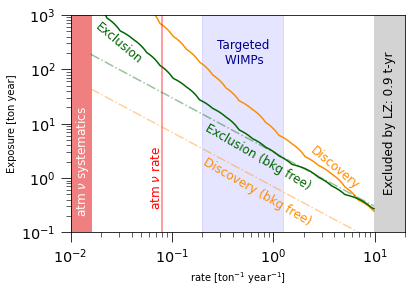

In [25]:
#adding labels:
def add_custom_label(x, y, theta, text, color, fontsize):
    plt.text(x, y, text, rotation=theta, color=color, fontsize=fontsize, ha='center', va='center')

LZrate=ratetots['MB']*2.9*(10**(-46))/(10**(-47))
nuuncertainty=0.2*ratetots['Bkg_NR_othernu']
# plt.plot(mydictofxy['LZ']['xdisc'],mydictofxy['LZ']['ydisc'],label='Projected Exposure for Discovery',color=mcolors.CSS4_COLORS['orange'])
# plt.plot(mydictofxy['LZ']['xexc'],mydictofxy['LZ']['yexc'],label='Projected Exposure for Exclusion',color='lightgreen')
xspace=np.exp(np.linspace(np.log(nuuncertainty),np.log(LZrate),num=1000))
yexcfunc=interpolate.interp1d(mydictofxy['LZ']['xexc'], mydictofxy['LZ']['yexc'],kind='linear', fill_value='extrapolate', bounds_error=False)
ydiscfunc=interpolate.interp1d(mydictofxy['LZ']['xdisc'], mydictofxy['LZ']['ydisc'],kind='linear', fill_value='extrapolate', bounds_error=False)
plt.plot(xspace,ydiscfunc(xspace),label='Projected Exposure for Discovery',color=mcolors.CSS4_COLORS['darkorange'])
plt.plot(xspace,yexcfunc(xspace),label='Projected Exposure for Discovery',color=mcolors.CSS4_COLORS['darkgreen'])

#the neutrino bkg rate. 
plt.plot(np.array([ratetots['Bkg_NR_othernu'],ratetots['Bkg_NR_othernu']]),[0.0001,100000],color='red',alpha=0.5)
#The following is the NR neutrino uncertainty
plt.fill_betweenx([0.0001, 1000000], [10**(-5),10**(-5)], np.array([nuuncertainty,nuuncertainty]), 
                  color=mcolors.CSS4_COLORS['lightcoral'],#mcolors.CSS4_COLORS['crimson'],
                  alpha=1)

#real multiplets:
# # 3let:
# plt.plot(np.array([0.24,0.24]),[0.0001,100000],color='blue',alpha=0.5)
# #5let
# plt.plot(np.array([0.46,0.46]),[0.0001,100000],color='blue',alpha=0.5)
# #7let
# plt.plot(np.array([0.52,0.52]),[0.0001,100000],color='blue',alpha=0.5)
# #9let
# plt.plot(np.array([0.62,0.62]),[0.0001,100000],color='blue',alpha=0.5)
# #11let
# plt.plot(np.array([0.78,0.78]),[0.0001,100000],color='blue',alpha=0.5)
# # 13let
# plt.plot(np.array([0.96,0.96]),[0.0001,100000],color='blue',alpha=0.5)

#complex multiplets:
# #3let:
# plt.plot(np.array([0.041,0.041]),[0.0001,100000],color='blue',alpha=0.5)
# #4let
# plt.plot(np.array([0.34,0.34]),[0.0001,100000],color='blue',alpha=0.5)
# #5let
# plt.plot(np.array([0.21,0.21]),[0.0001,100000],color='blue',alpha=0.5)
# #6let
# plt.plot(np.array([0.36,0.36]),[0.0001,100000],color='blue',alpha=0.5)
# #8let
# plt.plot(np.array([0.49,0.49]),[0.0001,100000],color='blue',alpha=0.5)
# #10let
# plt.plot(np.array([0.64,0.64]),[0.0001,100000],color='blue',alpha=0.5)
# #12let
# plt.plot(np.array([0.85,0.85]),[0.0001,100000],color='blue',alpha=0.5)

#the -one sigma of the triplet to the +one sigma of the 13let:
plt.fill_betweenx([0.0001, 1000000], [0.24-0.04,0.24-0.04], [0.96+0.28,0.96+0.28], color='blue', alpha=0.1)
plt.plot(xspace,np.log(20)/xspace,'-.',label='rate=-ln(0.05)/exposure',color=mcolors.CSS4_COLORS['darkgreen'],alpha=0.4)
plt.plot(xspace,np.log(2)/xspace,'-.',label='rate=-ln(0.5)/exposure',color=mcolors.CSS4_COLORS['darkorange'],alpha=0.4)

# plt.text(0.055, 0.01, 'atmospheric\n and DSN '+r'$\nu$'+' rate', rotation=90,color='red')

# plt.legend(loc="upper right")
plt.ylim(0.1,1000)
plt.xlim(0.01,20)
plt.yticks([10**i for i in range(-1, 3)])

# Set y-axis minor ticks
minor_ticks = []
for i in range(-1, 3):
    minor_ticks.extend([j * 10**i for j in range(1, 10)])
plt.gca().set_yticks(minor_ticks, minor=True)

#The following is the LZ excluded rate:
plt.fill_betweenx([0.0001, 1000000], [LZrate,LZrate], [100,100], color=mcolors.CSS4_COLORS['lightgray'], alpha=1)
add_custom_label(0.07,1,90,'atm '+r'$\nu$'+ ' rate','red',12)
add_custom_label(0.013,2,90,'atm '+r'$\nu$'+ ' systematics','white',12)
add_custom_label(0.5,200,0,'Targeted\n WIMPs',mcolors.CSS4_COLORS['darkblue'],12)
add_custom_label(14,10,90,'Excluded by LZ: 0.9 t-yr','black',12)

add_custom_label(4,1.5,320,'Discovery',mcolors.CSS4_COLORS['darkorange'],12)
add_custom_label(0.03,300,320,'Exclusion',mcolors.CSS4_COLORS['darkgreen'],12)

add_custom_label(0.7,0.55,330,'Discovery (bkg free)',mcolors.CSS4_COLORS['darkorange'],12)
add_custom_label(0.7,2.4,330,'Exclusion (bkg free)',mcolors.CSS4_COLORS['darkgreen'],12)


plt.ylabel('Exposure [ton year]')
plt.xlabel(r'${\rm rate}~[{\rm ton}^{-1}~{\rm year}^{-1}]$')

plt.xscale('log')
plt.yscale('log')
# plt.grid()
plt.savefig(datafolder+'expofrate.pdf', bbox_inches='tight', pad_inches=0.1)


## Cut and Count Analysis. Not used in the main plot, but is useful for some understandings of effective efficiencies, etc.

The following is defining the functions necessary to find the cut:

In [9]:

#Accurate discovery and exlcusion tests from eqs 8 and 9 of https://arxiv.org/pdf/2009.07249.pdf
def discoverytest(s0,b,signalscaling=1,exposure=1):
    s=s0*signalscaling
    return np.sqrt(2)*sc.erfcinv(sc.gammainc((s+b)*exposure,b*exposure)*2)
def exclusiontest(s0,b,signalscaling=1,exposure=1):
    s=s0*signalscaling
    return np.sqrt(2)*sc.erfcinv((1-sc.gammainc(b*exposure+1,(s+b)*exposure))*2)
#approximate discovery and exclusion tests from eqs 5 and 6 of https://arxiv.org/pdf/2009.07249.pdf and refs therein
def discoverytestimate(s0,b,signalscaling=1,exposure=1):
    s=s0*signalscaling
    return np.sqrt(2*((s + b)*np.log(1 + s/b) - s))*np.sqrt(exposure)
def exclusiontestimate(s0,b,signalscaling=1,exposure=1):
    s=s0*signalscaling
    return np.sqrt(2*(s-b*np.log(1+s/b)))*np.sqrt(exposure)
#Zeroth approxmiation for a cut. I simply use s/sqrt(s+b) as a proxy.
def zerothiteration(signals,backgrounds):
    ntots=signals+backgrounds
    mysigvec=signals[signals>0]
    ntotsvec=ntots[signals>0]
    mysigvecord=mysigvec[np.argsort(-mysigvec/ntotsvec)]
    ntotsveccord=ntotsvec[np.argsort(-mysigvec/ntotsvec)]
    previoussoversqrtb=-1
    currentsoversqrtb=0
    numnow=1
    while(currentsoversqrtb>previoussoversqrtb):
        previoussoversqrtb=currentsoversqrtb*1+0
        currentsoversqrtb=np.sum(mysigvecord[:numnow])/np.sqrt(np.sum(ntotsveccord[:numnow]))
        numnow=numnow+1
    if(numnow>len(mysigvecord)):
        numnow=len(mysigvecord)-1
    minsigovertot=mysigvecord[numnow]/ntotsveccord[numnow]
    masknow=signals*0
    for anum1 in range(len(signals)):
        for anum2 in range(len(signals[anum1])):
            if(backgrounds[anum1,anum2]>0):
                masknow[anum1,anum2]=(signals[anum1,anum2]/ntots[anum1,anum2]>minsigovertot)
    return masknow
#For each of the bins, see if according to a test, it is better to keep or remove it.
def nextiteration(signals,backgrounds,oldmask,currenttest):
    bkgtot=np.sum(np.sum(backgrounds*oldmask))
    sigtot=np.sum(np.sum(signals*oldmask))
    #this estimate is relevant if oldmask is true:
    #the following line is 1 if it's better to keep the bin
    newmaskpt1=(currenttest(sigtot-signals*oldmask,bkgtot-backgrounds*oldmask)<currenttest(sigtot,bkgtot))
    #the following line is 1 if it's better to change things, and take the bin
    newmaskpt2=(currenttest(sigtot,bkgtot)<currenttest(sigtot+signals*oldmask,bkgtot+backgrounds*oldmask))
    newmask=newmaskpt1*oldmask+(1-oldmask)*newmaskpt2
    return newmask

#I wanted to check that if I allow bins to be partially included, that doesn't change things:
def nextiterationAllowPartialBins(signals,backgrounds,oldmask,currenttest,oneoverresolution=5):
    #I am going to allow a bin to be partially true. The first step is the same as earlier, except I jump by 1/oneoverresolutionabitlarger    myres=1/oneoverresolution#
    myres=1/oneoverresolution#
    bkgtot=np.sum(np.sum(backgrounds*oldmask))
    sigtot=np.sum(np.sum(signals*oldmask))
    #construct three options:
    maskoptm1=atleast(oldmask-myres,0)-oldmask
    maskoptp1=atmost(oldmask+myres,1)-oldmask
    maskopt0=oldmask-oldmask
    stacked_tests = np.stack([currenttest(sigtot+maskoptm1*signals,bkgtot+maskoptm1*backgrounds), 
                              currenttest(sigtot,bkgtot)+maskopt0,
                              currenttest(sigtot+maskoptp1*signals,bkgtot+maskoptp1*backgrounds)], axis=-1)
    bestoptionforeachcell = np.argmax(stacked_tests, axis=-1)
#     print(np.argwhere((bestoptionforeachcell==0)*(np.abs(maskoptm1)>0)))
#     print(np.argwhere((bestoptionforeachcell==2)*(np.abs(maskoptp1)>0)))
    newmask=oldmask+maskoptm1*(bestoptionforeachcell==0)+maskoptp1*(bestoptionforeachcell==2)
    return newmask

#just find the mask, inputs:
#1. signal0now is the binned rate of the signal
#2. bkgs0now is the binned rate of the background
#3. technically the mask is different for the discovery and the exclusion, and even for different exposures and signal strengths
    #by using the discoverytestimate as a default, we ignore the exposure dependence, but not the signal strength one.
    #if one wants truly needs the optimal mask then one should optimize this everytime
#4. oneoverresoltion: to avoid falling into a local minimum, and as a sanity check, I allow the mask to include numbers
    #[0,1/oneoverresolution,2/oneoverresolution,...,1]. The final answer ends up having 0s and 1s only.
def findmask(signal0now,bkgs0now,whichtest=discoverytestimate,
             oneoverresolution=6,signormalization=1,exposure=1):
    itnum=1
    bkgs=bkgs0now*exposure
    signalrate=signal0now*exposure*signormalization
    oldmask=0
    newmask=zerothiteration(signalrate,bkgs)
    while((itnum<1000)&((1-0.1/oneoverresolution)>np.abs(np.prod(np.prod(1-np.abs(newmask-oldmask)))))):
        oldmask=deepcopy(newmask)
        if(oneoverresolution==1):
            newmask=nextiteration(signalrate,bkgs,oldmask,currenttest=whichtest,oneoverresolution=oneoverresolution)
        else:
            newmask=nextiterationAllowPartialBins(signalrate,bkgs,oldmask,currenttest=whichtest,oneoverresolution=oneoverresolution)
        itnum=itnum+1
    if(itnum>950):
        print('I may have not found the best mask out there....')
    return np.array(newmask)

#find a mask that takes the median of the S2 for each S1.
def findmedianmask(signal0now):
    oldmask=0
    newmask=signal0now*0+1
    ratetots=np.sum(signal0now*newmask,axis=1)
    for aloc in range(len(np.sum(signal0now*newmask,axis=1))):
        if(ratetots[aloc]>0):
            athingo=-1
            while(np.sum(signal0now*newmask,axis=1)[aloc]/ratetots[aloc]>1/2):
                newmask[aloc,athingo]=0
                athingo=athingo-1
    return np.array(newmask)

#perform a cut and count analysis. I assume signal rate and background rate are already simply numbers. 
#signal normalization vec is the things I will multiply the signal rate by, looking for the right exposure to detect them
def cutandcountanalysis(signalrate,backgroundrate,signalnormalizationvec,Zdiscovery=5,Zexclusion=1.645,fulldict=fulldict):
    yexc=signalnormalizationvec*0#The exposure for exclusion, I will fill this out as this function goes along
    ydisc=signalnormalizationvec*0#The exposure for discovery, I will fill this out as this function goes along
    # Initial guess for the first y
    yexcguess=9*backgroundrate/signalrate**2
    ydiscguess=25*backgroundrate/signalrate**2
    for i, aratenorm in enumerate(signalnormalizationvec):
        # Define the equation to solve for discovery
        def FindDiscoveryExposure(y):#when this is zero
            return discoverytest(signalrate,backgroundrate,signalscaling=aratenorm,exposure=y) - 5
        def FindExclusionExposure(y):#when this is zero
            return exclusiontest(signalrate,backgroundrate,signalscaling=aratenorm,exposure=y) - 1.64
        # Solve for discovery
        y_solution_Disc = fsolve(FindDiscoveryExposure, ydiscguess)
        # Solve for exclusion
        y_solution_Exc = fsolve(FindExclusionExposure, yexcguess)
        if(np.abs(FindExclusionExposure(y_solution_Exc[0]))>0.1):
            print(i,'exc')
            print(y_solution_Exc)
        if(np.abs(FindDiscoveryExposure(y_solution_Disc[0]))>0.1):
            print(i,'disc')
            print(y_solution_Disc)
        # Store the solution
        yexc[i] = y_solution_Exc[0]
        ydisc[i] = y_solution_Disc[0]

        # Use the current solution as the guess for the next y
        yexcguess=y_solution_Exc[0]
        ydiscguess=y_solution_Disc[0]
    return signalnormalizationvec*fulldict['ratetots'][fulldict['whichissig']],yexc,ydisc
    


#even though I let the mask include any number between 0 and 1, the final answer is 0s and 1s.
#note that technically the mask is different for the discovery and the exclusion, and even for different
#signal strengths and exposures. However, by using the discovery testimate, we ignore the exposure dependence but not the signal!. 
newmask=findmask(signalrate,bkgs)
fulldict['mask']=deepcopy(newmask)




In [11]:
#for creating the rgb plot:
bkgnr=0
bkger=0
for akey in fulldict['keynames']:
    if(akey==fulldict['whichissig']):
        sigo=fulldict['BinnedSpect'][akey]
    elif(fulldict['NRorER'][akey]=='NR'):
        bkgnr=bkgnr+fulldict['BinnedSpect'][akey]
    elif(akey==fulldict['whichiscontaminant']):
        if(not(NoERcontamination)):
            bkger=bkger+fulldict['BinnedSpect'][akey]
    else:
        bkger=bkger+fulldict['BinnedSpect'][akey]
# bkgnr=np.log(bkgnr+1)
# sigo=np.log(sigo+1)
# bkger=np.log(bkger+1)
bkgnr=atmost(bkgnr/np.max(sigo),1)
bkger=atmost(bkger/np.max(sigo),1)
sigo=atmost(sigo/np.max(sigo),1)

rgb_image = 1-np.stack([bkger.T, bkgnr.T, sigo.T], axis=-1)

In [12]:
#for depicting the mask in the rgb plot:
maskedgesx=[]
maskedgesymin=[]
maskedgesymax=[]

for abusha in range(len(newmask)):
    if(np.max(newmask[abusha])>0.5):
        maskedgesx.append(fulldict['S1bins'][abusha])
        maskedgesymin.append(fulldict['S2bins'][np.min(np.argwhere(newmask[abusha]>0.5))])
        maskedgesymax.append(fulldict['S2bins'][np.max(np.argwhere(newmask[abusha]>0.5))+1])
maskedgesx=[maskedgesx[0]]+maskedgesx
maskedgesymax=[maskedgesymax[0]]+maskedgesymax
maskedgesymin=[maskedgesymax[0]]+maskedgesymin

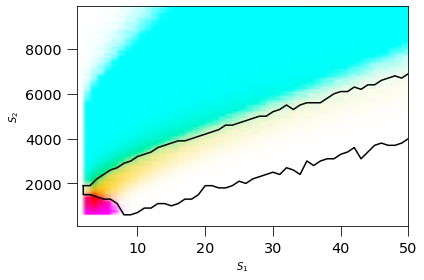

In [11]:
#the heatmap plot:
def add_custom_label(x, y, theta, text, color, fontsize):
    plt.text(x, y, text, rotation=theta, color=color, fontsize=fontsize, ha='center', va='center')

fig, ax = plt.subplots()
ax.imshow(rgb_image,
           extent=[fulldict['S1bins'][0], fulldict['S1bins'][-1],
                   fulldict['S2bins'][0], fulldict['S2bins'][-1]],
           origin='lower', cmap='coolwarm', aspect='auto')
# plt.plot(running_mean(maskedgesx,4),running_mean(maskedgesymin,4),'black')
# plt.plot(running_mean(maskedgesx,4),running_mean(maskedgesymax,4),'black')
plt.plot(maskedgesx,maskedgesymin,'black')
plt.plot(maskedgesx,maskedgesymax,'black')

ax.set_facecolor('white')
plt.ylim(100,9900)
plt.xlim(1,50)
plt.xlabel(r'$S_1$')
plt.ylabel(r'$S_2$')
plt.tight_layout()
fig.savefig('HeatMapV0.pdf')

In [21]:
t0=tic()
nsimstempy=10000
enervecforeffsNR=np.concatenate([np.arange(0.1,6,0.1),np.arange(6.5,50,1),np.arange(51,110,2)])
NReff=[]
for anenernum in range(len(enervecforeffsNR)):
    anener=enervecforeffsNR[anenernum]
    if(np.mod(anenernum,10)==0):
        print(anener,toc(t0))
    s1temp,s2temp=GetS1_S2(interaction=nestpy.nr,energykeV=np.arange(nsimstempy)*0+anener,detector=currentdetector)
    newhist,_,_=np.histogram2d(s1temp, s2temp, bins=(fulldict['S1bins'], fulldict['S2bins']))
    NReff.append(np.sum(newmask*newhist)/nsimstempy)


0.1 0.0009469985961914062
1.1 1.6726362705230713
2.1 3.2872960567474365
3.1 4.958623170852661
4.1 6.639523267745972
5.1 8.29433822631836
7.5 9.979400157928467
17.5 11.694756269454956
27.5 13.498463153839111
37.5 15.376930236816406
47.5 17.35716724395752
65.0 19.57310128211975
85.0 21.899670124053955
105.0 24.294114112854004


In [39]:
enervecforeffsER=np.concatenate([np.arange(0.1,6,0.2),np.arange(6.3,17,0.6)])
EReff=[]
t0now=tic()
tnow=deepcopy(t0now)
nsimsnow=(4*10**5)
print(len(enervecforeffsER))
for anenernum,anener in enumerate(enervecforeffsER):
    if(toc(tnow)>25):
        nsimsnow=int(nsimsnow/1.5)
        print('faster')
    tnow=tic()
    s1temp,s2temp=GetS1_S2(interaction=nestpy.beta,energykeV=np.arange(nsimsnow)*0+anener,detector=currentdetector)
    histtemp,_,_=np.histogram2d(s1temp, s2temp, bins=(fulldict['S1bins'], fulldict['S2bins']))
    EReff.append(np.sum(histtemp*newmask)/nsimsnow)
    if(np.mod(anenernum,10)==0):
        print(anener,toc(t0now))

48
0.1 6.450621843338013
2.1000000000000005 74.39169192314148
4.1000000000000005 145.22250699996948
6.3 218.67234778404236
12.299999999999997 297.76442217826843


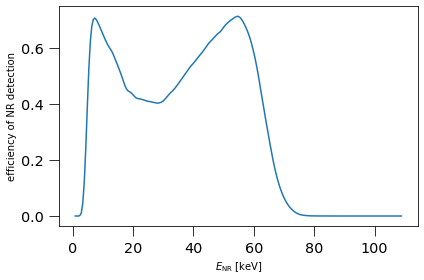

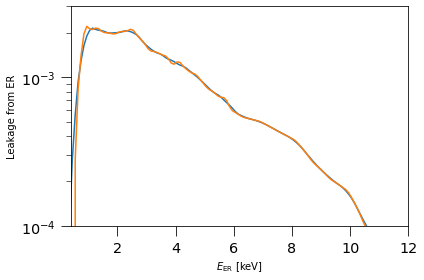

In [57]:
#efficiency curves (slightly smoothed to look nicer)
interpNREff=interpolate.interp1d(enervecforeffsNR, NReff,
                                      kind='linear', fill_value=0, bounds_error=False)#linear interp of the efficiency
plt.plot(running_mean(np.arange(0.1,110,0.5),4),running_mean(interpNREff(np.arange(0.1,110,0.5)),4))
plt.xlabel(r'$E_{\rm NR}~[{\rm keV}]$')
plt.ylabel('efficiency of NR detection')
plt.tight_layout()
plt.savefig('NREffV0.pdf')
plt.show()
# plt.plot(enervecforeffsER,EReff)
interpNREff=interpolate.interp1d(enervecforeffsER, EReff,
                                      kind='linear', fill_value=0, bounds_error=False)#linear interp of the efficiency
plt.plot(running_mean(np.arange(0.1,17,0.1),6),running_mean(interpNREff(np.arange(0.1,17,0.1)),6))
plt.plot(running_mean(np.arange(0.1,17,0.1),2),running_mean(interpNREff(np.arange(0.1,17,0.1)),2))
plt.ylim(10**(-4),3*10**(-3))
plt.xlim(0.4,12)
plt.yscale('log')
plt.xlabel(r'$E_{\rm ER}~[{\rm keV}]$')
plt.ylabel('Leakage from ER')
plt.tight_layout()
plt.savefig('EREffV0.pdf')


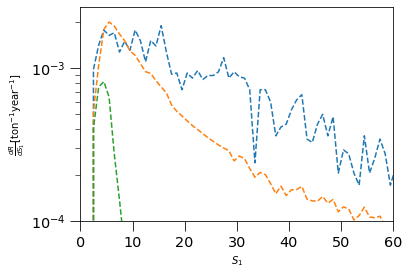

In [21]:
runthiscell=False
#plots the S1 distribution post-masking. Removed from main paper, because it is somewhat misleading considering that 
#the code is not optimized for this. 
if(runthiscell):
    plt.plot((fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,np.sum(fulldict['BinnedSpect']['Bkg_ER_solarnu']*newmask,axis=1),'--')#,color=mcolors.CSS4_COLORS['magenta'])
    plt.plot((fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,np.sum(fulldict['BinnedSpect']['Bkg_NR_othernu']*newmask,axis=1),'--')#,color=mcolors.CSS4_COLORS['darkblue'])
    plt.plot((fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,np.sum(fulldict['BinnedSpect']['Bkg_NR_solarnu']*newmask,axis=1),'--')#,color=mcolors.CSS4_COLORS['darkgreen'])
    plt.ylim(10**(-4),0.0025)
    plt.xlim(0,60)
    plt.xlabel(r'$S_{1}$')
    plt.ylabel(r'$\frac{dR}{dS_{1}}[{\rm ton}^{-1}{\rm year}^{-1}]$')
    plt.tight_layout()
    plt.yscale('log')

In [ ]:
#Checking number of events in different scenarios. Not crucial for main run. But can be informative
runthiscell=False
if(runthiscell):
    ERsolar=np.trapz(x=(fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_ER_solarnu']*newmask,axis=1))
    NRnu=np.trapz(x=(fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_NR_othernu']*newmask,axis=1))
    NRSolar=np.trapz(x=(fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_NR_solarnu']*newmask,axis=1))

    print(ERsolar,NRnu,NRSolar)

    ERsolar=np.trapz(x=(fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_ER_solarnu']*newmaskmed,axis=1))
    NRnu=np.trapz(x=(fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_NR_othernu']*newmaskmed,axis=1))
    NRSolar=np.trapz(x=(fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_NR_solarnu']*newmaskmed,axis=1))

    print(ERsolar,NRnu,NRSolar)

    ERsolar=np.trapz(x=(fulldict['S1bins'][10:-1]+fulldict['S1bins'][11:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_ER_solarnu']*newmaskmed,axis=1)[10:])
    NRnu=np.trapz(x=(fulldict['S1bins'][10:-1]+fulldict['S1bins'][11:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_NR_othernu']*newmaskmed,axis=1)[10:])
    NRSolar=np.trapz(x=(fulldict['S1bins'][10:-1]+fulldict['S1bins'][11:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_NR_solarnu']*newmaskmed,axis=1)[10:])

    print(ERsolar,NRnu,NRSolar)



    ERsolar=np.trapz(x=(fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_ER_solarnu']*newmaskmed*newmask,axis=1))
    NRnu=np.trapz(x=(fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_NR_othernu']*newmaskmed*newmask,axis=1))
    NRSolar=np.trapz(x=(fulldict['S1bins'][:-1]+fulldict['S1bins'][1:])/2,y=np.sum(fulldict['BinnedSpect']['Bkg_NR_solarnu']*newmaskmed*newmask,axis=1))

    print(ERsolar,NRnu,NRSolar)


# This is the code that saves the S1S2 pdfs

In [3]:
def CalcS1S2SpectofEnergy(anener,interaction,detector,nsims=10**5,S1Binsnum=100,S2Binsnum=100,maxS1=99,maxS2=9900,chunk_size=10**5):
    if(interaction=='NR'):#NR or ER
        intnow=nestpy.nr
    elif(interaction=='ER'):
        intnow=nestpy.beta
    else:
        error#Should always be ER or NR
    S1results = []
    S2results = []
    for i in range(0, nsims, chunk_size):
        chunk=0*np.arange(nsims)[i:i+chunk_size]+anener
        anS1RawDatResult,anS2RawDatResult=GetS1_S2(interaction=intnow,energykeV=chunk,detector=detector)#get the S1S2spect
        S1results.append(anS1RawDatResult)
        S2results.append(anS2RawDatResult)
    anS1RawDat=np.concatenate(S1results).astype(np.float32)
    anS2RawDat=np.concatenate(S2results).astype(np.float32)
    S1bins=np.linspace(0,maxS1,S1Binsnum)#the analysis used here has a hard cut at S1=3. However, some S1s are actually smaller than 3.
    S2bins=np.linspace(0,maxS2,S2Binsnum)#Similar to before, except here the lower bound is 500. 
    BinnedS1S2, _,_=np.histogram2d(anS1RawDat, anS2RawDat, bins=(S1bins, S2bins))
    #this is the PDF, normalized so that the sum is nsims up to efficiency.
    return BinnedS1S2
#the following saves the NR and ER spectrums in a specific int-dominated format, meant to save space as much as possible, 
    #while being loadable by either mathematica or python easily (and being human readable). 
def SaveNRERSpects(enerlistNR,enerlistER,detector,folderloc,nsims=10**5,S1Binsnum=100,S2Binsnum=100,maxS1=99,maxS2=9900,chunk_size=10**5):
    enerlistER=np.sort(enerlistER)#If I don't sort them my life will be harder later
    enerlistNR=np.sort(enerlistNR)#If I don't sort them my life will be harder later
    if not os.path.exists(folderloc):
        os.makedirs(folderloc)
    #save information about the details of the saving
    file_name=folderloc+'SaveDetails.txt'
    S1bins=np.linspace(0,maxS1,S1Binsnum)#the analysis used here has a hard cut at S1=3. However, some S1s are actually smaller than 3.
    S2bins=np.linspace(0,maxS2,S2Binsnum)#Similar to before, except here the lower bound is 500. 
    with open(file_name, 'w') as file:
        file.write(",".join(map(str, S1bins)))#save S1 bins
        file.write(f"\n")
        file.write(",".join(map(str, S2bins)))#save S2 bins
        file.write(f"\n")
        file.write(",".join(map(str, enerlistNR)))# save energy list NR
        file.write(f"\n")
        file.write(",".join(map(str, enerlistER)))#save energy list ER
        file.write(f"\n")
        file.write(str(nsims))#save energy list ER
        file.write(f"\n")
        file.write(str(detector))#save the detector name. Not actually "useful" in the sense of being able to load it, but healthy to have.
    for enernum,anener in tqdm(enumerate(enerlistNR),total=len(enerlistNR)):
        SpectNow=CalcS1S2SpectofEnergy(anener,'NR',detector=detector,nsims=nsims,S1Binsnum=S1Binsnum,
                                       S2Binsnum=S2Binsnum,maxS1=maxS1,maxS2=maxS2,chunk_size=chunk_size)
        #I want to save this as sparse matrix to not take too much data:
        coo = coo_matrix(SpectNow)
        rows, cols, values = coo.row, coo.col, coo.data
        file_name=folderloc+'Spectrum_NR_Enum='+str(enernum)+'.txt'
        with open(file_name, 'w') as file:
            file.write(",".join(map(str, rows)))#save rows
            file.write(f"\n")
            file.write(",".join(map(str, cols)))#save cols
            file.write(f"\n")
            file.write(",".join(map(str, values)))# save values
#             for i1, i2, f in zip(rows, cols, values):
#                 file.write(f"{i1} {i2} {f}\n")
    for enernum,anener in tqdm(enumerate(enerlistER),total=len(enerlistER)):
        SpectNow=CalcS1S2SpectofEnergy(anener,'ER',detector=detector,nsims=nsims,S1Binsnum=S1Binsnum,
                                       S2Binsnum=S2Binsnum,maxS1=maxS1,maxS2=maxS2,chunk_size=chunk_size)
        #I want to save this as sparse matrix to not take too much data:
        coo = coo_matrix(SpectNow)
        rows, cols, values = coo.row, coo.col, coo.data
        file_name=folderloc+'Spectrum_ER_Enum='+str(enernum)+'.txt'
        with open(file_name, 'w') as file:
            file.write(",".join(map(str, rows)))#save rows
            file.write(f"\n")
            file.write(",".join(map(str, cols)))#save cols
            file.write(f"\n")
            file.write(",".join(map(str, values)))# save values
#             for i1, i2, f in zip(rows, cols, values):
#                 file.write(f"{i1} {i2} {f}\n")
        
def calculate_center(spectrum):#Calculate the center of a spectrum
    total_sum = np.sum(spectrum)
    if(total_sum>0):
        x_indices, y_indices = np.indices(spectrum.shape)
        y_center = np.trapz(np.trapz(spectrum * x_indices, axis=1), axis=0) / total_sum
        x_center = np.trapz(np.trapz(spectrum * y_indices, axis=0)) / total_sum
    else:
        x_center=0
        y_center=0
    return (x_center, y_center)
def interpolatedspect(spect1,spect2,weight):#interpolate between two spectra with a certain weight by shifting both to the new center first
    x1,y1=calculate_center(spect1)
    x2,y2=calculate_center(spect2)
    newcenter=((y1*weight+(1-weight)*y2),(x1*weight+(1-weight)*x2))
    shift1=(newcenter[0]-y1,newcenter[1]-x1)
    shift2=(newcenter[0]-y2,newcenter[1]-x2)
    return weight*scipy.ndimage.shift(spect1, shift1, mode='constant',order=1)+(1-weight)*scipy.ndimage.shift(spect2, shift2, mode='constant',order=1)


def LoadASpect(foldername,InteractionKind,Energy,Interpolate=False):#Interpolate is probably a bit slower, but is meant to be a better representation of the specific spectrum.
    #The interpolate is only worth doing if one is looking at mono-energetic peaks. Otherwise it probably does not matter
    file_name=foldername+'SaveDetails.txt'
    with open(file_name, 'r') as file:
        S1bins = np.fromstring(file.readline().strip(), sep=',')
        S2bins = np.fromstring(file.readline().strip(), sep=',')
        enerlistNR = np.fromstring(file.readline().strip(), sep=',')
        enerlistER = np.fromstring(file.readline().strip(), sep=',')
        nsims = int(file.readline().strip())
    if(InteractionKind=='ER'):
        enervec=enerlistER
    elif(InteractionKind=='NR'):
        enervec=enerlistNR
    else:
        ERROR
    bestnum=np.argmin(np.abs(enervec-Energy))
    spect=np.zeros((len(S1bins)-1,len(S2bins)-1))
    filename=foldername+'Spectrum_'+InteractionKind+'_Enum='+str(bestnum)+'.txt'
    with open(filename, 'r') as file:
        rows = np.fromstring(file.readline().strip(), sep=',',dtype=int)
        cols = np.fromstring(file.readline().strip(), sep=',',dtype=int)
        values = np.fromstring(file.readline().strip(), sep=',')
    spect[rows, cols] = values/nsims
    if(Interpolate&(bestnum!=0)&(bestnum!=len(enervec)-1)&(np.abs(enervec-Energy)>10**(-3))):#Should I interpolate?
        if(enervec[bestnum]-Energy<0):
            secondbestnum=bestnum+1
        else:
            secondbestnum=bestnum-1
        spect2=np.zeros((len(S1bins)-1,len(S2bins)-1))
        filename=foldername+'Spectrum_'+InteractionKind+'_Enum='+str(secondbestnum)+'.txt'
        with open(filename, 'r') as file:
            rows = np.fromstring(file.readline().strip(), sep=',',dtype=int)
            cols = np.fromstring(file.readline().strip(), sep=',',dtype=int)
            values = np.fromstring(file.readline().strip(), sep=',')
        spect2[rows, cols] = values/nsims
        weight=(enervec[secondbestnum]-Energy)/(enervec[secondbestnum]-enervec[bestnum])
        spect=interpolatedspect(spect,spect2,weight)
    return spect,S1bins,S2bins

In [4]:
spectfolder=datafolder+'Spectra/'
SaveNRERSpects(enerlistNR=np.arange(3.0,70.0,0.5),enerlistER=np.arange(0.4,15.0,0.2),detector=currentdetector,folderloc=spectfolder)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [02:03<00:00,  1.69s/it]


Low Res things

In [74]:
#cut and count:
#Looking at what happens with no ER:
xexclusion,yexclusion=doexclusionsearch(signalrate,bkgs,npoissonsims=10000,
                                        signalnormalizationvec=np.exp(np.linspace(np.log(0.05),np.log(100),num=6)),
                                        masknow=newmask)
xdiscovery,ydiscovery=dodiscoverysearch(signalrate,bkgs,npoissonsims=10000,
                                        signalnormalizationvec=np.exp(np.linspace(np.log(0.05),np.log(100),num=6)),
                                        masknow=newmask)
mydictofxy['mymask']={'xdisc':deepcopy(xdiscovery),'ydisc':deepcopy(ydiscovery),
                   'xexc':deepcopy(xexclusion),'yexc':deepcopy(yexclusion)}


6
1 27.672216653823853
2 83.05961489677429
3 128.28587579727173
4 165.37279176712036
5 201.93349504470825
6 240.0137128829956
6
1 26.720284938812256
2 93.22649598121643
3 154.87000107765198
4 206.15057015419006
5 270.71247005462646
6 304.4783010482788


In [75]:
#Looking at what happens with no ER:
xexclusion,yexclusion=doexclusionsearch(signalrate,bkgs,npoissonsims=10000,
                                        signalnormalizationvec=np.exp(np.linspace(np.log(0.05),np.log(100),num=6)),
                                        masknow=newmask)
xdiscovery,ydiscovery=dodiscoverysearch(signalrate,bkgs,npoissonsims=10000,
                                        signalnormalizationvec=np.exp(np.linspace(np.log(0.05),np.log(100),num=6)),
                                        masknow=newmask)
mydictofxy['maskmed']={'xdisc':deepcopy(xdiscovery),'ydisc':deepcopy(ydiscovery),
                   'xexc':deepcopy(xexclusion),'yexc':deepcopy(yexclusion)}


6
1 27.474565744400024
2 78.58487796783447
3 129.48206686973572
4 160.7616310119629
5 194.647784948349
6 235.77089405059814
6
1 29.285202026367188
2 99.00764298439026
3 156.60409212112427
4 210.75500202178955
5 273.4467730522156
6 306.8341770172119


In [146]:
mydictofxy['cutandcountmed']={'xexc':xboth,'xdisc':xboth,'ydisc':ydiscnow,'yexc':yexcnow}

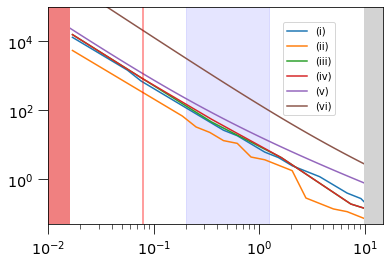

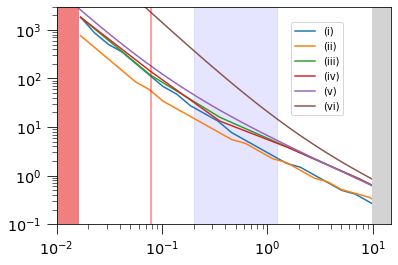

In [33]:
plt.fill_betweenx([0.0001, 1000000], [LZrate,LZrate], [100,100], color=mcolors.CSS4_COLORS['lightgray'], alpha=1,zorder=2)
plt.fill_betweenx([0.0001, 1000000], [10**(-5),10**(-5)], np.array([nuuncertainty,nuuncertainty]), 
                  color=mcolors.CSS4_COLORS['lightcoral'],#mcolors.CSS4_COLORS['crimson'],
                  alpha=1,zorder=2)

for anum in range(6):
    akey=[ 'LZ', 'LZ_NoER','mymask', 'maskmed', 'cutandcount', 'cutandcountmed'][anum]
    alabel=['(i)','(ii)','(iii)','(iv)','(v)','(vi)'][anum]
#     plt.plot(mydictofxy[akey]['xdisc'],mydictofxy[akey]['ydisc']*mydictofxy[akey]['xdisc'],label=akey)
    plt.plot(mydictofxy[akey]['xdisc'],mydictofxy[akey]['ydisc'],label=alabel)
plt.legend(loc=(0.7,0.5))
plt.xscale('log')
plt.yscale('log')
plt.fill_betweenx([0.0001, 1000000], [10**(-5),10**(-5)], np.array([nuuncertainty,nuuncertainty]), 
                  color=mcolors.CSS4_COLORS['lightcoral'],#mcolors.CSS4_COLORS['crimson'],
                  alpha=1,zorder=2)

plt.fill_betweenx([0.0001, 1000000], [0.24-0.04,0.24-0.04], [0.96+0.28,0.96+0.28], color='blue', alpha=0.1)
plt.fill_betweenx([0.0001, 1000000], [LZrate,LZrate], [100,100], color=mcolors.CSS4_COLORS['lightgray'], alpha=1)

plt.plot(np.array([ratetots['Bkg_NR_othernu'],ratetots['Bkg_NR_othernu']]),[0.0001,100000],color='red',alpha=0.5)
plt.fill_betweenx([0.0001, 1000000], [LZrate,LZrate], [100,100], color=mcolors.CSS4_COLORS['lightgray'], alpha=1,zorder=2)

plt.xlim(0.01,15)

plt.ylim(0.05,100000)
plt.savefig(datafolder+'expofrate_compdisc.pdf', bbox_inches='tight', pad_inches=0.1)

plt.show()
plt.fill_betweenx([0.0001, 1000000], [LZrate,LZrate], [100,100], color=mcolors.CSS4_COLORS['lightgray'], alpha=1,zorder=2)

for anum in range(6):
    akey=[ 'LZ', 'LZ_NoER','mymask', 'maskmed', 'cutandcount', 'cutandcountmed'][anum]
    alabel=['(i)','(ii)','(iii)','(iv)','(v)','(vi)'][anum]
#     plt.plot(mydictofxy[akey]['xexc'],mydictofxy[akey]['yexc']*mydictofxy[akey]['xexc'],label=akey)
    plt.plot(mydictofxy[akey]['xexc'],mydictofxy[akey]['yexc'],label=alabel)
plt.legend(loc=(0.7,0.5))
plt.xscale('log')
plt.yscale('log')
plt.fill_betweenx([0.0001, 1000000], [10**(-5),10**(-5)], np.array([nuuncertainty,nuuncertainty]), 
                  color=mcolors.CSS4_COLORS['lightcoral'],#mcolors.CSS4_COLORS['crimson'],
                  alpha=1)
plt.fill_betweenx([0.0001, 1000000], [LZrate,LZrate], [100,100], color=mcolors.CSS4_COLORS['lightgray'], alpha=1,zorder=2)

plt.fill_betweenx([0.0001, 1000000], [0.24-0.04,0.24-0.04], [0.96+0.28,0.96+0.28], color='blue', alpha=0.1)
plt.plot(np.array([ratetots['Bkg_NR_othernu'],ratetots['Bkg_NR_othernu']]),[0.0001,100000],color='red',alpha=0.5)

plt.xlim(0.01,15)
plt.ylim(0.1,3000)
plt.savefig(datafolder+'expofrate_compexc.pdf', bbox_inches='tight', pad_inches=0.1)


In [41]:
# save_pkl(mydictofxy,datafolder+'discoveryexclusiondict.pkl')
mydictofxy=load_pkl(datafolder+'discoveryexclusiondict.pkl')


# This is calculations

In [13]:
mydictofxy.keys()


dict_keys(['mymask', 'maskmed', 'LZ', 'LZ_NoER', 'cutandcount', 'cutandcountmed'])

In [14]:
len(['mymask', 'maskmed', 'LZ', 'LZ_NoER', 'cutandcount', 'cutandcountmed'])

6